In [29]:
import os
import numpy as np
import pandas as pd

import rocks
rocks.set_log_level("error")

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import figure_setup as fs


In [2]:
# G12 line in G1G2 space
def G12_to_G1G2(g12):

    G1_a, G2_a = 0.0, 0.53513350
    G1_b, G2_b = 0.84293649, -0.53513350

    G1 = G1_a + g12 * G1_b
    G2 = G2_a + g12 * G2_b

    return G1, G2

# Simple 1D Gaussian
def gauss(x, m, mu, sigma):
    return m * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Two 1D Gaussians
def double_gauss(x, m1, mu1, sigma1, m2, mu2, sigma2):
    g1 = gauss(x, m1, mu1, sigma1)
    g2 = gauss(x, m2, mu2, sigma2)
    return g1 + g2

# Get ZTF fit

In [3]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [4]:
# ZTF filters
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


mag_to_V ={
        1: -0.2833,  # ZTF g
        2: 0.1777,   # ZTF r
        3: 0.4388,   # ATLAS orange
        4: -0.0986   # ATLAS cyan
    }

fink_colors = ['#15284F', '#F5622E']


In [32]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [33]:
bft.columns[ bft.columns.str.contains(r'^(?=.*Atlas)(?=.*orange)')]

Index(['phase_functions.Misc/Atlas.orange.H.value',
       'phase_functions.Misc/Atlas.orange.H.error.min',
       'phase_functions.Misc/Atlas.orange.H.error.max',
       'phase_functions.Misc/Atlas.orange.G1.value',
       'phase_functions.Misc/Atlas.orange.G1.error.min',
       'phase_functions.Misc/Atlas.orange.G1.error.max',
       'phase_functions.Misc/Atlas.orange.G2.value',
       'phase_functions.Misc/Atlas.orange.G2.error.min',
       'phase_functions.Misc/Atlas.orange.G2.error.max',
       'phase_functions.Misc/Atlas.orange.N',
       'phase_functions.Misc/Atlas.orange.phase.min',
       'phase_functions.Misc/Atlas.orange.phase.max',
       'phase_functions.Misc/Atlas.orange.rms',
       'phase_functions.Misc/Atlas.orange.facility',
       'phase_functions.Misc/Atlas.orange.technique',
       'phase_functions.Misc/Atlas.orange.name_filter'],
      dtype='object')

In [34]:
bft = pd.read_parquet(bft_file)

In [35]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "orbital_elements.semi_major_axis.value",
    "orbital_elements.eccentricity.value",
    "orbital_elements.inclination.value",
    "orbital_elements.node_longitude.value",
    "orbital_elements.perihelion_argument.value",
    "orbital_elements.mean_anomaly.value",
    "orbital_elements.mean_motion.value",
    "family.family_number",
    "family.family_name",
    "tisserand_parameters.Jupiter.value",
    "albedo.value",
    "absolute_magnitude.value",
    "diameter.value",
    "taxonomy.class",
    "taxonomy.complex",
    "taxonomy.waverange",
    "taxonomy.scheme",
    "taxonomy.technique",
    "colors.g-r.color.value",
    "colors.g-r.color.error.min",
    "colors.g-r.color.error.max",
    "colors.g-r.facility",
    "colors.g-r.observer",
    "colors.g-r.epoch",
    "colors.g-r.delta_time",
    "colors.g-r.id_filter_1",
    "colors.g-r.id_filter_2",
    "colors.g-r.phot_sys",
    "colors.g-r.technique",
    "phase_functions.Misc/Atlas.orange.H.value",
    "phase_functions.Misc/Atlas.orange.G1.value",
    "phase_functions.Misc/Atlas.orange.G2.value",
    "spins.1.obliquity",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.long.value",
    "spins.1.lat.value",
    "spins.1.technique",
    "spins.2.obliquity",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.long.value",
    "spins.2.lat.value",
    "spins.2.technique",
    "spins.3.obliquity",
    "spins.3.RA0.value",
    "spins.3.DEC0.value",
    "spins.3.long.value",
    "spins.3.lat.value",
    "spins.3.technique",
    "spins.4.obliquity",
    "spins.4.RA0.value",
    "spins.4.DEC0.value",
    "spins.4.long.value",
    "spins.4.lat.value",
    "spins.4.technique",
]

data = data.merge(bft[cols], left_on="name", right_on="sso_name", how="left")

In [36]:
data.columns[ data.columns.str.contains('Atlas')]

Index(['phase_functions.Misc/Atlas.orange.H.value',
       'phase_functions.Misc/Atlas.orange.G1.value',
       'phase_functions.Misc/Atlas.orange.G2.value'],
      dtype='object')

In [37]:
len(data)

115147

# Compare results

In [38]:
data.HG1G2_status.value_counts()

 2.0    106453
 4.0      6708
 1.0      1248
 3.0       497
-2.0       238
 0.0         3
Name: HG1G2_status, dtype: int64

In [39]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_sHG1G2_g = (data.sHG1G2_G1_g>thres)  & (data.sHG1G2_G2_g>thres) & ((1-data.sHG1G2_G1_g-data.sHG1G2_G2_g)>thres)
mask_sHG1G2_r = (data.sHG1G2_G1_r>thres)  & (data.sHG1G2_G2_r>thres) & ((1-data.sHG1G2_G1_r-data.sHG1G2_G2_r)>thres)
mask_sHG1G2_ZTF = mask_sHG1G2_g & mask_sHG1G2_r
mask_sHG1G2_fit = (data.sHG1G2_fit==0)  & (data.sHG1G2_status>=2)
mask_sHG1G2 = mask_sHG1G2_fit & mask_sHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.sHG1G2_alpha0>thres) & ( np.abs(360-data.sHG1G2_alpha0)>thres )  & \
           ( np.abs(data.sHG1G2_alpha0-180)>thres) & ( np.abs(data.sHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.minphase<2.5

# Global mask
mask = mask_HG1G2 & mask_sHG1G2


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_sHG1G2_g]):6d}  ({100.*len(data[mask_sHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_sHG1G2_r]):6d}  ({100.*len(data[mask_sHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_sHG1G2]):6d}  ({100.*len(data[mask_sHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for minphase in [2,3,4,5]:
    maskPhase = data.minphase<minphase
    print(f'  Mask phase {minphase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_sHG1G2_g]), len(data[mask_sHG1G2_r]), len(data[mask_sHG1G2])

 All data       : 115147  (100.00%)



  Mask HG g      : 114904  ( 99.79%)
  Mask HG r      : 114906  ( 99.79%)
  Mask HG g+r    : 112564  ( 97.76%)

  Mask HG1G2 g   :  56815  ( 49.34%)
  Mask HG1G2 r   :  62043  ( 53.88%)
  Mask HG1G2 g+r :  40727  ( 35.37%)

  Mask SHG1G2 g  :  70736  ( 61.43%)
  Mask SHG1G2 r  :  75544  ( 65.61%)
  Mask SHG1G2 g+r:  55579  ( 48.27%)

  Mask Spin      : 111357  ( 96.71%)

  Mask (both)    :  34691  ( 30.13%)
  Mask phase 2  :  57515  ( 49.95%)
  Mask phase 3  :  79455  ( 69.00%)
  Mask phase 4  :  93564  ( 81.26%)
  Mask phase 5  : 101933  ( 88.52%)


## Difference in absolute magnitude

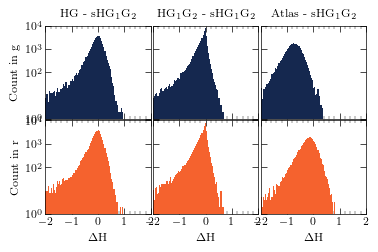

In [57]:
# HG vs HG1G2
fig, ax = plt.subplots(
    2,
    3,
    figsize=fs.figsize(0.5),
    sharex=True,
    sharey=True,
    gridspec_kw={
        "hspace": 0.02,
        "wspace": 0.02,
        "top": 0.96,
        "bottom": 0.12,
        "left": 0.095,
        "right": 0.98,
    },
)

r = [-2, 2]
b = 100

# --------------------------------------------------------------------------------
for i, f in enumerate(["g", "r"]):
    x = data[f"HG_H_{f}"] - data[f"sHG1G2_H_{f}"]
    ax[i, 0].hist(x[mask_HG1G2], range=r, bins=b, label=f"{f}", color=fink_colors[i], alpha=1)

    x = data[f"HG1G2_H_{f}"] - data[f"sHG1G2_H_{f}"]
    ax[i, 1].hist(x[mask_HG1G2], range=r, bins=b, label=f"{f}", color=fink_colors[i], alpha=1)

    x = data[f"phase_functions.Misc/Atlas.orange.H.value"] - data[f"sHG1G2_H_{f}"]
    ax[i, 2].hist(x[mask_HG1G2], range=r, bins=b, label=f"{f}", color=fink_colors[i])

# --------------------------------------------------------------------------------
for a in ax.ravel():
    # a.set_xlabel('$\Delta H$')
    # a.legend(loc='upper left')
    a.set_yscale("log")

# ax[1, 0].set_xlabel("$\Delta$H = HG - sHG$_1$G$_2$")
# ax[1, 1].set_xlabel("$\Delta$H = HG$_1$G$_2$ - sHG$_1$G$_2$")
# ax[1, 2].set_xlabel("$\Delta$H = HG$_1$G$_2$ Atlas - sHG$_1$G$_2$")

ax[1, 0].set_xlabel("$\Delta$H")
ax[1, 1].set_xlabel("$\Delta$H")
ax[1, 2].set_xlabel("$\Delta$H")

ax[0,0].set_yticks([1,1e2,1e3,1e4])
ax[0,0].set_xticks([-2,-1,0,1,2])

ax[0,0].set_ylabel('Count in g')
ax[1,0].set_ylabel('Count in r')
# ax[1,0].set_yminor(5)

ax[0,0].set_title('HG - sHG$_1$G$_2$', fontsize='small')
ax[0,1].set_title('HG$_1$G$_2$ - sHG$_1$G$_2$', fontsize='small')
ax[0,2].set_title('Atlas - sHG$_1$G$_2$', fontsize='small')


# --------------------------------------------------------------------------------
fig.savefig(
    os.path.join(data_fink, "gfx", "article", "abs_mag.png"),
    facecolor="orange",
)

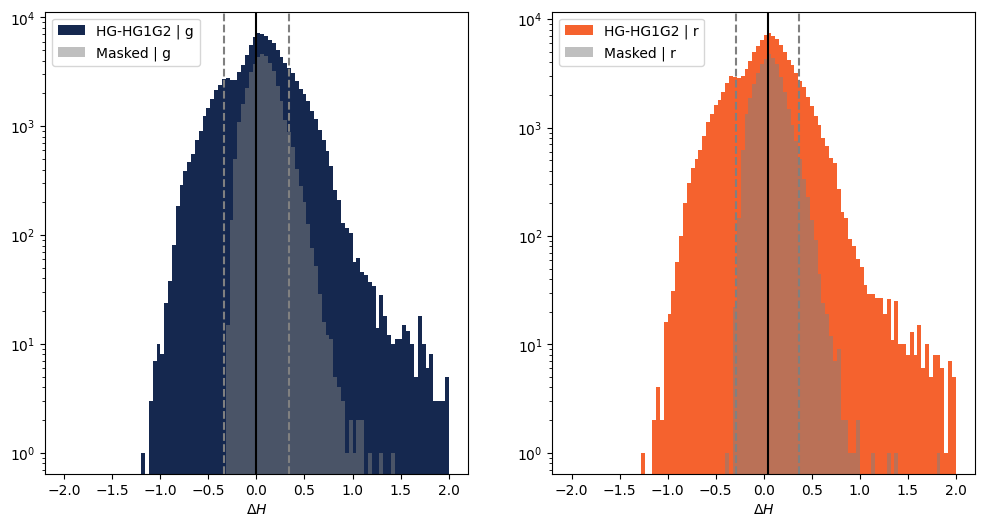

In [14]:
# HG vs HG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'HG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-HG1G2 | {f}', color=fink_colors[i] )
    statarr.append([hb[ np.argmax(hn) ], np.std(x)])

    ax[i].hist( x[mask_HG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'eltaH_HG_HG1G2.png'), facecolor='white')

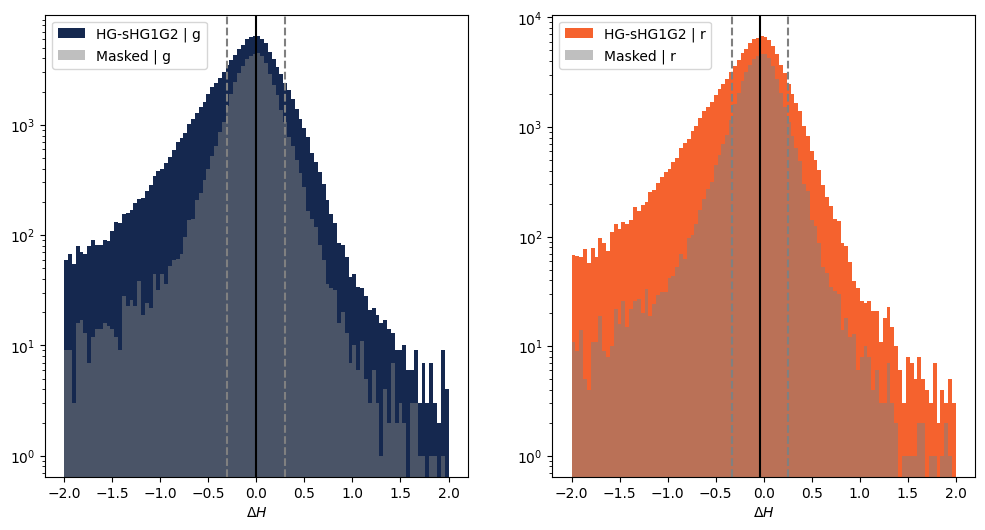

In [15]:
# HG vs sHG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG_H_{f}'] - data[f'sHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG-sHG1G2 | {f}', color=fink_colors[i] )

    hn, hb, _ = ax[i].hist( x[mask_sHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )
    statarr.append([hb[ np.argmax(hn) ], np.std(x[mask_sHG1G2])])
    
    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG_sHG1G2.png'), facecolor='white')

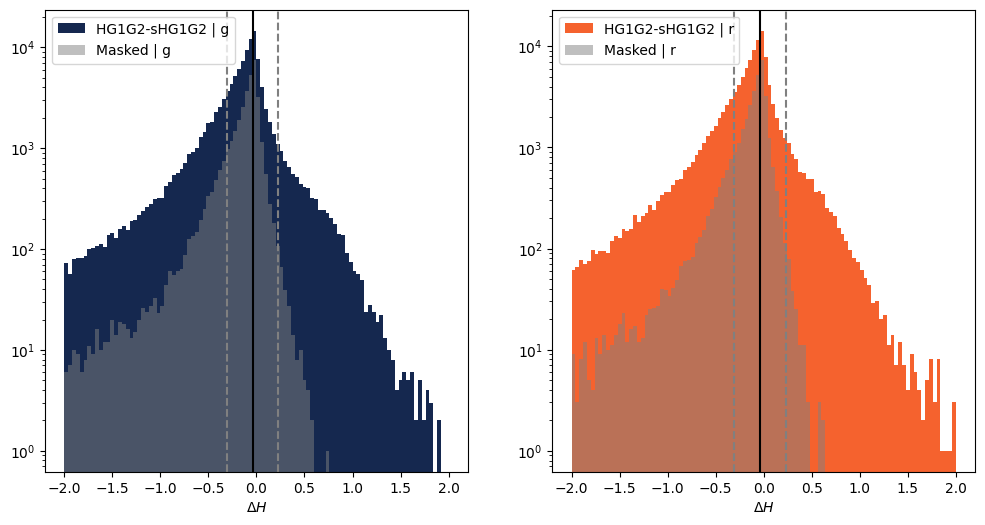

In [16]:
# HG vs sHG1G2
fig, ax = plt.subplots(1, 2, figsize=(12,6))

r = [-2,2]
b = 100

statarr = []
for i,f in enumerate(['g','r']):
    
    x = data[f'HG1G2_H_{f}'] - data[f'sHG1G2_H_{f}']

    hn, hb, _ = ax[i].hist( x, range=r, bins=b, label=f'HG1G2-sHG1G2 | {f}', color=fink_colors[i] )

    hn, hb, _ = ax[i].hist( x[mask_HG1G2&mask_sHG1G2], range=r, bins=b, label=f'Masked | {f}', color='grey', alpha=0.5 )
    statarr.append([hb[ np.argmax(hn) ], np.std(x[mask_HG1G2&mask_sHG1G2])])

    ax[i].axvline( statarr[i][0], color='black' )
    ax[i].axvline( statarr[i][0]-statarr[i][1], color='gray', linestyle='dashed' )
    ax[i].axvline( statarr[i][0]+statarr[i][1], color='gray', linestyle='dashed' )
    
for a in ax:
    a.set_xlabel('$\Delta H$')
    a.legend(loc='upper left')
    a.set_yscale('log')
    
fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'deltaH_HG1G2_sHG1G2.png'), facecolor='white')

- HG seems to fail as expected
- HG1G2 vs spin non symmetric: effect of oppositions
- Hspin often smaller

Apparently a systematic larger value of H (HG) wrt H (hybrid)

H_s = m - f - g - s
    = H - s

so
H_S - H = - s
 s s always negative -> H_S - H > 0
  
unless the issues with geometry are modifying g, so everything is messed up in non-hybrid model!
  

1 HG_H_r HG1G2_H_r
2 HG_H_r sHG1G2_H_r
3 HG1G2_H_r sHG1G2_H_r


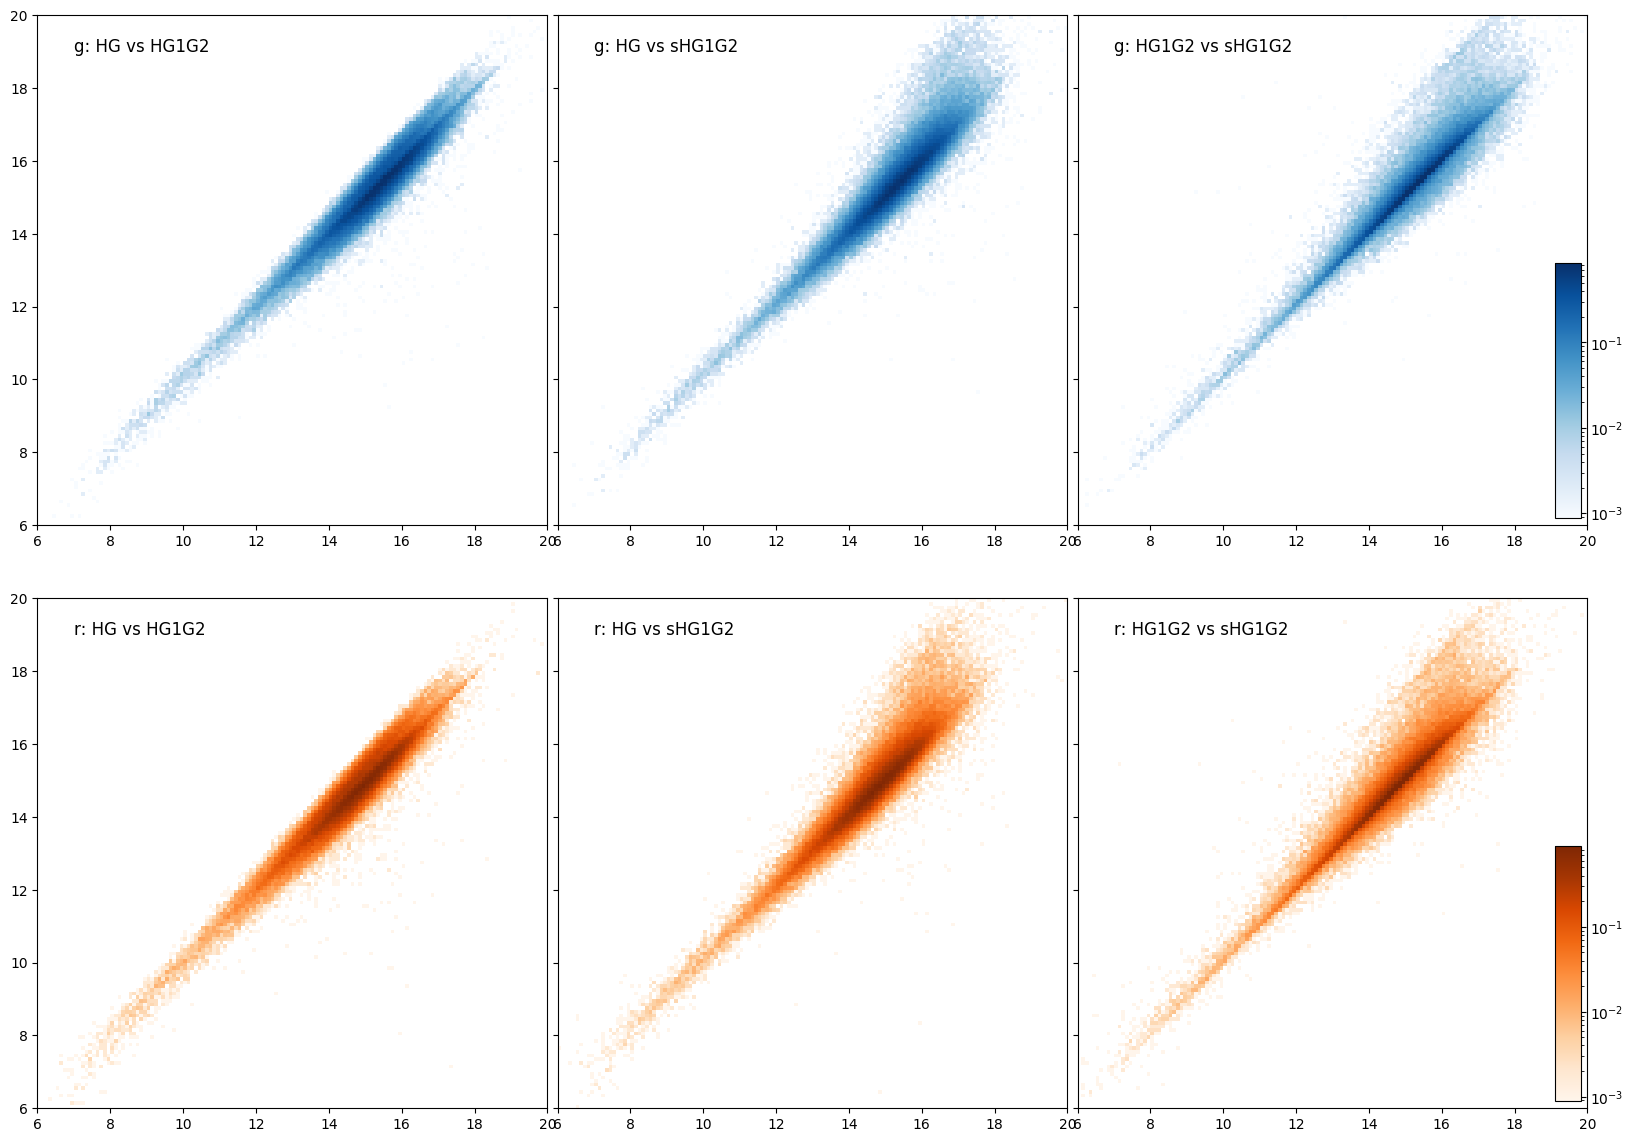

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(20,15), gridspec_kw={'hspace':0.02, 'wspace':0.02})

hh_r = [ [0,22], [0,22] ]
bb_r = np.array([1,1]) * 88
xlab, ylab = 2,20

hh_r = [ [6,20], [6,20] ]
bb_r = np.array([1,1]) * (hh_r[0][1] - hh_r[0][0])*10
xlab, ylab = 7,19

models = ['HG','HG1G2','sHG1G2']
for i in range(3):
    for j in range(i+1,3):

        mx = models[i]
        my = models[j]
        loc_f = 'r'
        print( i+j, f'{mx}_H_{loc_f}', f'{my}_H_{loc_f}' )
        
        # Filter g
        x = data[f'{mx}_H_g']
        y = data[f'{my}_H_g']
        loc_cmap = 'Blues' 
        _ , _, _, img = ax[0,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[0,i+j-1].text( xlab, ylab, f'g: {mx} vs {my}', fontsize='large' )
        
        # Filter r
        x = data[f'{mx}_H_r']
        y = data[f'{my}_H_r']
        loc_cmap = 'Oranges' 
        _ , _, _, imr = ax[1,i+j-1].hist2d( x, y, range=hh_r, bins=bb_r, cmap=loc_cmap, norm='log', density=True )
        ax[1,i+j-1].text( xlab, ylab, f'r: {mx} vs {my}', fontsize='large' )

        ax[0,i+j-1].set_aspect('equal')
        ax[1,i+j-1].set_aspect('equal')
        
        if (i+j-1)>0:
            ax[0,i+j-1].set_yticklabels('')
            ax[1,i+j-1].set_yticklabels('')
    
axinsg = inset_axes(
    ax[0,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(img, cax=axinsg)


axinsr = inset_axes(
    ax[1,2],
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="lower right",
)
fig.colorbar(imr, cax=axinsr)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'scatterH_HG1G2_sHG1G2.png'), facecolor='white')